## Práca s algoritmom K-Means

na tomto príklade si ukážeme prácu s algoritmom K-Means na jednoduchom príklade. 

Ukážeme si vytvorenie zhlukovacieho modelu na dátach, ktoré popisujú klientov veľkoobchodného predajcu. Pozostáva z informácií, ktoré charakterizujú ročné nákupy čerstvých, mliečnych, potravinových a iných produktov. Každý klient je popísaný nasledovnými atribútmi:
* Fresh - ročné výdajne na čerstvé produkty 
* Milk - ročné výdajne na mliečne produkty
* Grocery - ročné výdajne na potravinové produkty
* Frozen - ročné výdajne na mrazené produkty 
* Detergents_Paper - ročné výdajne na čistiace a papierové produkty
* Delicassen - ročné výdajne na delikatesy
* Channel - spôsob predaja zákazníkom hotnoty - Horeca (Hotel/Restaurant/Cafe) alebo Retail
* Region - nominálne hodnoty, zodpovedajú Lisbon, Porto alebo Other

Cieľom je vytvoriť zhlukovací model, ktorý by našiel v množine skupiny rôznych typov zákazníkov.

Najprv importujeme potrebné knižnice. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Načítame dáta zo súboru do dátového rámca a vypíšeme hlavičku. 

In [2]:
data = pd.read_csv('../data/wholesale.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Keďže dataset obsahuje 2 kategorické atribúty (Channel a Region), tieto stĺpce transformujeme pomocou One Hot Encoder prístupu. 

In [3]:
data = pd.get_dummies(data, columns=['Channel', 'Region']) 
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


V prípade zhlukovania pomocou K-Means je veľmi podstatnou časťou výpočet vzdialeností jednotlivých príkladov od centier zhlukov. Aby sme zabezpečili rovnakú dôležitosť všetkých atribútov, tak ich normalizujeme na rovnaký rozsah. Podobne ako pri klasifikácii môžeme použiť `MinMaxScaler`, na celý dátový rámec (normalizujeme všetky atribúty).

Môžeme pretransformovať normalizované dáta do dátového rámca (ale nemusíme, ďalšie funkcie môžu pracovať s numpy poľom, ktoré dostaneme na výstupe normalizácie). 

In [4]:
from sklearn.preprocessing import MinMaxScaler # importujeme MinMaxScaler

scaler = MinMaxScaler() # Inicializujeme transformátor
scaler.fit(data) # aplikujeme ho na vstupné dáta

# po aplikovaní scaleru budeme mať výstup vo forme numpy poľa
# to môžeme - ale nemusíme - naspať transformovať do pandas rámca (ak chceme ešte robiť nejaké predspracovanie)
# funkcie pre trénovanie modelov potom vedia pracovať aj s pandas aj s numpy

# data_norm = scaler.transform(data)
data_norm = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

Teraz vytvoríme K-Means zhlukovací model, ktorý natrénujeme na vstupných dátach. Implementácia K-Means v Sciki-learn umožňuje nasledovné nastavenia algoritmu (vybrali sme iba niektoré):
* n_clusters - zodpovedá hodnote parametra `k`, definuje počet zhlukov
* max_iter - zodpovedá maximálnemu počtu iterácií algoritmu (defaultná hodnota - 300)

Ako výstup po vytvorení modelu môžeme použiť:
* cluster_centers_ - pole súradníc centroidov pre jednotlivé zhluky
* labels_ - príslušnosť k zhlukom pre všetky objekty vstupných dát
* inertia_ - suma štvorcov vzdialeností príkladov k centroidu (kritérium)

In [5]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(data_norm)
# labels = model.predict(data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Môžeme teraz vypísať napr. sumu štvorcov vzdialeností v rámci zhlukov pre vytvorený model alebo napr. spočítať vzdialenosti medzi jednotlivými centroidmi. 

In [6]:
from sklearn.metrics.pairwise import euclidean_distances # importujeme funkciu euclidean_distances ktorá nám spočíta vzdialenosti medzi zadanými bodmi

print("Inertia:") # zobrazíme vypočítanú inertiu
print(model.inertia_)

print("Vzajomne vzdialenosti centroidov:")
dists = euclidean_distances(model.cluster_centers_) # spočítame vzdialenosti medzi centrami zhlukov a vypíšeme ich
print(dists)

Inertia:
71.38989240243725
Vzajomne vzdialenosti centroidov:
[[0.         1.43259636 1.45406245 1.52873624]
 [1.43259636 0.         1.78884615 1.65216422]
 [1.45406245 1.78884615 0.         1.43513713]
 [1.52873624 1.65216422 1.43513713 0.        ]]


Takisto sa vieme pozrieť na obsah jednotlivých zhlukov. Pomocou `model.labels_` sa vieme pozrieť na to, do ktorých zhlukov model pridelil jednotlivé príklady zo vstupnej množiny dát. Môžeme sa takisto pozrieť na konkrétny zhluk a príklady, ktoré doň patria. 

In [7]:
print("Príklady a ich príslušnosť do zhlukov:")
print(model.labels_) # vypíšeme príslušnost k zhluku pre každý príklad

Príklady a ich príslušnosť do zhlukov:
[1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0
 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [8]:
print("Príklady zo zhluku 0:")
cluster_0 = np.where(model.labels_==0) # vyberieme len príklady, ktoré patria do zhluku 0
print(cluster_0) # vypíšeme ich na obrazovku

Príklady zo zhluku 0:
(array([  3,   8,  15,  17,  19,  21,  22,  26,  27,  29,  30,  31,  32,
        33,  34,  36,  39,  40,  41,  50,  51,  54,  55,  58,  59,  64,
        66,  68,  69,  70,  71,  72,  75,  76,  78,  79,  80,  83,  87,
        88,  89,  90,  91,  93,  95,  97,  98,  99, 103, 104, 105, 110,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125,
       126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 157, 161, 162, 167, 168, 169, 172, 174, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 194, 195,
       273, 274, 275, 276, 277, 278, 280, 282, 283, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 342, 344, 345, 348, 350, 352, 354, 355,
       356, 358, 359, 360, 361, 362, 363, 364, 366, 367, 368, 369, 371,
       372, 374, 375, 377, 378, 380, 381, 382, 383, 384, 385, 386, 387,
       388, 389, 390, 391, 392, 393, 394,

Teraz si ukážeme ako môžeme porovnať dva zhluky navzájom. 

Vytvorím si teraz dátové rámce (nenormalizované) z príkladov pre jednotlivé zhluky. Teraz sa môžem pozrieť na obsah jednotlivých zhlukov a porovnať ich spoločné vlastnosti alebo rozdiely. 

In [9]:
cluster_1 = np.where(model.labels_==1) # nájdeme príklady priradené do zhluku 1

data_cluster_0 = data.iloc[cluster_0] # dátový rámec z príkladov pre zhluk 0
data_cluster_1 = data.iloc[cluster_1] # dátový rámec z príkladov pre zhluk 1

In [10]:
data_cluster_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.0,211.0,211.0,211.0,211.0
mean,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360,1.0,0.0,0.0,0.0,1.0
std,14746.572913,4508.505269,3593.506056,4956.590848,1099.970640,3663.183304,0.0,0.0,0.0,0.0,0.0
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,1.0,0.0,0.0,0.0,1.0
25%,3702.500000,1188.500000,1666.000000,779.000000,176.500000,378.500000,1.0,0.0,0.0,0.0,1.0
50%,9612.000000,2247.000000,2642.000000,1960.000000,375.000000,823.000000,1.0,0.0,0.0,0.0,1.0
75%,18821.000000,4205.000000,4927.500000,4542.500000,948.500000,1582.000000,1.0,0.0,0.0,0.0,1.0
max,112151.000000,43950.000000,21042.000000,36534.000000,6907.000000,47943.000000,1.0,0.0,0.0,0.0,1.0


In [11]:
data_cluster_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.0,105.0,105.0,105.0,105.0
mean,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524,0.0,1.0,0.0,0.0,1.0
std,9635.394129,10574.827178,12298.935356,1504.498737,6022.091110,2119.052222,0.0,0.0,0.0,0.0,0.0
min,23.000000,1124.000000,4523.000000,33.000000,523.000000,3.000000,0.0,1.0,0.0,0.0,1.0
25%,2343.000000,6128.000000,9170.000000,437.000000,3537.000000,545.000000,0.0,1.0,0.0,0.0,1.0
50%,7362.000000,7845.000000,12121.000000,1059.000000,5121.000000,1386.000000,0.0,1.0,0.0,0.0,1.0
75%,15076.000000,11114.000000,19805.000000,2194.000000,7677.000000,2158.000000,0.0,1.0,0.0,0.0,1.0
max,44466.000000,73498.000000,92780.000000,8132.000000,40827.000000,16523.000000,0.0,1.0,0.0,0.0,1.0


Na porovnanie zhlukov môžeme robiť aj vizualizácie pomocou Seaborn.

### Úloha

Vizualizujte pomocou Seaborn napr.: 
* Distribúcie hodnôt zvolených atribútov pre jednotlivé zhluky
* Priemery hodnôt zvolených atribútov jednotlivých zhlukov  

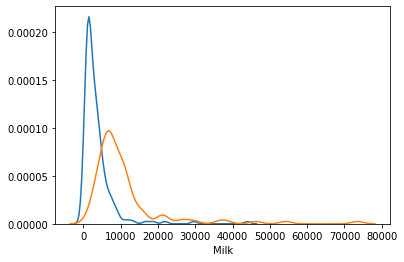

In [14]:
import seaborn as sns

g = sns.distplot(data_cluster_0['Milk'], hist = False)
g = sns.distplot(data_cluster_1['Milk'], hist = False)

Ako nájsť najlepšiu hodnotu počtu zhlukov? Môžeme použiť tzv. "elbow" metódu. Podobne ako pri Grid Search vytvoríme množinu modelov s rôznymi hodnotami parametra. Avšak v tomto prípade budeme potrebovať aj nejaké kritérium, ktoré by nám niečo povedalo o samotných zhlukoch. 

Keďže používame model K-Means, môžeme hľadať optimálny počet zhlukov tak, že budeme pre jednotlivé modely počítať sumu štvorcov vzdialeností príkladov zatriedených do zhluku k ich centroidu. Túto hodnotu vieme z modelu získať ako jeden z jeho 

In [15]:
Sum_of_squared_distances = [] # prázdne pole stvorcov vzdialeností

K = range(1,15) # vygeneruje rozsah parametrov K

# v cykle vytboríme modely s rôznymy nastaveniami

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_norm)
    Sum_of_squared_distances.append(km.inertia_)
    
print(Sum_of_squared_distances)

[411.82878995921095, 213.39898477020844, 117.07252399254907, 73.63235109910806, 37.922437718162826, 19.418928179725288, 15.67916418107215, 13.129100808295878, 11.729722696142492, 10.661939686227818, 9.994688834525094, 9.046767350093067, 8.140291491648567, 7.984903918406944]


Môžeme vizializovať závislosť počtu zhlukov od ich "kompaktnosti".

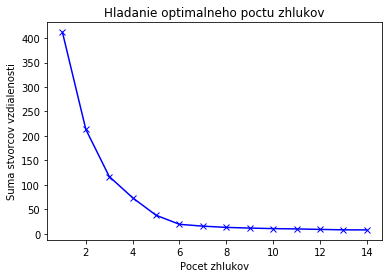

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Pocet zhlukov')
plt.ylabel('Suma stvorcov vzdialenosti')
plt.title('Hladanie optimalneho poctu zhlukov')
plt.show()